<a href="https://colab.research.google.com/github/angular654/AI_DATA_HACK/blob/main/AI_Data_hack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Решение кейса представляет собой
модель, автоматизированной оценки
соответствия указанных в реестре отрасли, подотрасли, технологий и категории
продукта неструктурированному массиву данных по компании (сайты и описания
компании и продукта).

In [ ]:
%matplotlib inline
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nltk
from nltk.corpus import stopwords
from string import punctuation
from pymystem3 import Mystem

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 # nltk examples https://nlpub.ru/NLTK

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import shutil

In [ ]:
shutil.unpack_archive(os.path.join('/content/drive/MyDrive', 'hackaton.zip'), '/content')
path = "/content/Source_Data/"

In [ ]:
company_df = pd.read_excel(os.path.join(path, 'company.xlsx'))
industries_df = pd.read_excel(os.path.join(path, 'industries.xlsx'))
names = ['global_id (продукта)',    'Компания',  'Рыночное наименование продукта',  'Раздел (ОКПД 2)',  'Класс (ОКПД 2)',    'Подкласс (ОКПД 2)',   'Группа (ОКПД 2)',  'Подгруппа (ОКПД 2)',   'Вид (ОКПД 2)', 'Категория (ОКПД 2)',   'Подкатегория (ОКПД 2)',    'Описание продукта']
products_new_df = pd.read_excel(os.path.join(path, 'products_new.xlsx'), names=names)
technology_df = pd.read_excel(os.path.join(path, 'technology.xlsx'))

In [ ]:
companies_names = company_df['Наименование поддержанной компании'] 

In [ ]:
company_df.drop(['global_id', 'Наименование поддержанной компании', 'Сайт'],inplace=True , axis=1)

In [ ]:
columns_company = company_df.columns
for el in columns_company[:5]:
   company_df["Описание компании"] += company_df[el]
len(company_df["Описание компании"].iloc[0])

643

In [ ]:
#company_df.drop(company_df.loc[company_df['Отрасль']=='н/д'].index, inplace=True)

In [ ]:
len(set(company_df['Отрасль']))

21

In [ ]:
#otrasl = company_df['Отрасль'].unique()
#otrasl = dict(zip(otrasl, range(len(otrasl))))
#company_df.replace({'Отрасль': otrasl})

In [ ]:
company_df["Описание компании"].describe().top

'ЦМИТ «АКВИЛ» создает и поддерживает условия для занятия детей и подростков техническим творчеством и знакомит их с инженерным делом.\nРабота Центра организована в формате лабораторий, где слушатели занимаются малыми группами, сформированными по возрасту и уровню подготовки. Наставниками юных исследователей в лабораториях являются сотрудники и выпускники Самарского национального исследовательского университета имени академика С.П. Королева.\n\nШкольники в лабораториях приобретают навыки работы с обоПРОЧАЯ ДЕЯТЕЛЬНОСТЬПрочие услугиСинтез информацииСинтез контентаСинтез образовательного контента'

In [ ]:
STOPWORDS = set(stopwords.words("russian"))
MAX_NB_WORDS = 2000
MAX_SEQUENCE_LENGTH = 250


def clean_text(text):
    text = text.lower()
    text = text.replace('\n', ' ')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text
company_df["Описание компании"] = company_df["Описание компании"].apply(clean_text)
company_df.head()

,Отрасль,Подотрасль,Технология (1 уровень),Технология (2 уровень),Технология (3 уровень),Описание компании
0,СЕЛЬСКОЕ ХОЗЯЙСТВО (ВКЛЮЧАЯ РЫБОЛОВСТВО),Растениеводство,Синтез материальных объектов,Синтез живых организмов и систем,Технологии селекции растений,ооо «агроплазма» является оригинатором патенто...
1,ТЕЛЕКОММУНИКАЦИИ И ИНТЕРНЕТ,Деятельность по созданию новых информационных ...,Синтез информации,Искусственный интеллект,"Обработка естественных языков (перевод, класси...","""лаборатория наносемантика"" — ведущий российск..."
2,ПРОМЫШЛЕННОСТЬ,"Металлургия, металлопродукция, производство го...",Синтез материальных объектов,Новые производственные процессы,Технологии сварки и пайки,"компания ""romet"" специализируется производстве..."
3,ТЕЛЕКОММУНИКАЦИИ И ИНТЕРНЕТ,Разработка аппаратно-программных комплексов,Обработка и преобразование информации,Обработка и хранение больших данных,Интерфейсы обмена большими данными,компания 2can решает проблему приема денежных ...
4,ТЕЛЕКОММУНИКАЦИИ И ИНТЕРНЕТ,Специализированные информационные системы,Синтез информации,Синтез контента,Синтез образовательного контента,"""учи.ру"" — крупнейшая отечественная образовате..."


Модель (lstm, Sequtial)

In [ ]:
labels_list = []
for column in company_df.columns:
   labels_list.append(company_df[column])
labels_list.pop(-1)
labels_list

[0                СЕЛЬСКОЕ ХОЗЯЙСТВО (ВКЛЮЧАЯ РЫБОЛОВСТВО)
 1                             ТЕЛЕКОММУНИКАЦИИ И ИНТЕРНЕТ
 2                                          ПРОМЫШЛЕННОСТЬ
 3                             ТЕЛЕКОММУНИКАЦИИ И ИНТЕРНЕТ
 4                             ТЕЛЕКОММУНИКАЦИИ И ИНТЕРНЕТ
                               ...                        
 3712    ИССЛЕДОВАНИЯ И ИНЖЕНЕРНО-ТЕХНИЧЕСКОЕ ПРОЕКТИРО...
 3713                          ТЕЛЕКОММУНИКАЦИИ И ИНТЕРНЕТ
 3714                          ТЕЛЕКОММУНИКАЦИИ И ИНТЕРНЕТ
 3715                                       ПРОМЫШЛЕННОСТЬ
 3716                                       ПРОМЫШЛЕННОСТЬ
 Name: Отрасль, Length: 3717, dtype: object,
 0                                         Растениеводство
 1       Деятельность по созданию новых информационных ...
 2       Металлургия, металлопродукция, производство го...
 3             Разработка аппаратно-программных комплексов
 4               Специализированные информационные системы
           

In [ ]:
import io

def create_company_info_dir():
  os.mkdir('/content/description_cmp')
  for i in range(len(company_df["Описание компании"])):
    with io.open(f"/content/description_cmp/text_{i}.txt", 'w', encoding='utf8') as stream:
      content = company_df["Описание компании"].loc[i]
      STOPWORDS.add(companies_names[0])
      content = ' '.join([word for word in content.split(' ') if word not in STOPWORDS])
      stream.write(content)
      
create_company_info_dir()
len(os.listdir('/content/description_cmp'))

3717

In [ ]:
shutil.rmtree('/content/description_cmp')

In [ ]:
shutil.rmtree('/content/Отрасль')

In [ ]:
# формирование датасетов по лейблам
os.mkdir('/content/Отрасль') 
def create_dataset(dir, labels_list_item, pd_df, category):
  train_images = os.listdir(dir)
  print(len(set(labels_list_item)))
  input()
  for i in range(len(labels_list_item)):
      train_directory = os.path.join(dir, str(labels_list_item[i]))
      try:
        if labels_list_item[i] != 'н/д':
          os.mkdir(train_directory)
      except:
          pass
      try:
       shutil.move(f'/content/description_cmp/text_{i}.txt', train_directory)
      except:
        pass
create_dataset('/content/Отрасль', labels_list[0], company_df, 'Отрасль')

21



In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
shutil.rmtree('/content/отрасль_ds')

In [ ]:
import splitfolders
splitfolders.ratio('Отрасль', output="отрасль_ds", seed=1337, ratio=(.7, 0.2,0.1))

Copying files: 3715 files [00:01, 3407.14 files/s]


In [ ]:
batch_size = 32
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "отрасль_ds/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
)
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "отрасль_ds/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
)
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "отрасль_ds/test", batch_size=batch_size
)

Found 2590 files belonging to 20 classes.
Using 2072 files for training.
Found 2590 files belonging to 20 classes.
Using 518 files for validation.
Found 389 files belonging to 20 classes.


In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'\xc2\xab\xd0\xa2\xd0\xa0\xd0\xad\xd0\x92\xd0\x95\xd0\x9b \xd0\x9e\xd0\xa4\xd0\x98\xd0\xa1 \xd0\x9f\xd0\xa0\xd0\x9e\xc2\xbb \xd1\x81\xd0\xbe\xd0\xb7\xd0\xb4\xd0\xb0\xd0\xbd\xd0\xbe \xd0\xb7\xd0\xb0\xd1\x80\xd0\xb5\xd0\xb3\xd0\xb8\xd1\x81\xd1\x82\xd1\x80\xd0\xb8\xd1\x80\xd0\xbe\xd0\xb2\xd0\xb0\xd0\xbd\xd0\xbe 3 \xd0\xb0\xd0\xbf\xd1\x80\xd0\xb5\xd0\xbb\xd1\x8f 2019 \xd0\xb3\xd0\xbe\xd0\xb4\xd0\xb0. \xd0\x9e\xd0\xb1\xd0\xbb\xd0\xb0\xd1\x81\xd1\x82\xd1\x8c \xd0\xb4\xd0\xb5\xd1\x8f\xd1\x82\xd0\xb5\xd0\xbb\xd1\x8c\xd0\xbd\xd0\xbe\xd1\x81\xd1\x82\xd0\xb8 \xd0\xbf\xd1\x80\xd0\xb5\xd0\xb4\xd0\xbf\xd1\x80\xd0\xb8\xd1\x8f\xd1\x82\xd0\xb8\xd1\x8f - \xd1\x80\xd0\xb0\xd0\xb7\xd1\x80\xd0\xb0\xd0\xb1\xd0\xbe\xd1\x82\xd0\xba\xd0\xb0 \xd0\xba\xd0\xbe\xd0\xbc\xd0\xbf\xd1\x8c\xd1\x8e\xd1\x82\xd0\xb5\xd1\x80\xd0\xbd\xd0\xbe\xd0\xb3\xd0\xbe \xd0\xbf\xd1\x80\xd0\xbe\xd0\xb3\xd1\x80\xd0\xb0\xd0\xbc\xd0\xbc\xd0\xbd\xd0\xbe\xd0\xb3\xd0\xbe \xd0\xbe\xd0\xb1\xd0\xb5\xd1\x81\xd0\xbf\xd0\xb5\xd1\x87\xd0\xb5

In [ ]:
# Слой векторизации слов для обучения
import re
import string

max_features = 10000
sequence_length = 100


vectorize_layer = tf.keras.layers.TextVectorization (
    split='whitespace',
    ngrams=True,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

NameError: ignored

In [ ]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'\xd0\x9a\xd0\xbe\xd0\xbc\xd0\xbf\xd0\xb0\xd0\xbd\xd0\xb8\xd1\x8f \xd0\x9e\xd0\x9e\xd0\x9e "\xd0\xa2\xd0\xb5\xd0\xbb\xd0\xb5\xd0\xbf\xd0\xbe\xd1\x80\xd1\x82 \xd0\xa0\xd1\x83\xd1\x81\xd1\x8c" \xd1\x80\xd0\xb0\xd0\xb7\xd1\x80\xd0\xb0\xd0\xb1\xd0\xb0\xd1\x82\xd1\x8b\xd0\xb2\xd0\xb0\xd0\xb5\xd1\x82 \xd0\xb2\xd0\xbd\xd0\xb5\xd0\xb4\xd1\x80\xd1\x8f\xd0\xb5\xd1\x82 \xd1\x80\xd0\xb5\xd1\x88\xd0\xb5\xd0\xbd\xd0\xb8\xd0\xb5 Teleport Media. \xd0\xad\xd1\x82\xd0\xbe \xd0\xbf\xd0\xb8\xd1\x80\xd0\xb8\xd0\xbd\xd0\xb3\xd0\xbe\xd0\xb2\xd0\xb0\xd1\x8f CDN \xd0\xbe\xd0\xbd\xd0\xbb\xd0\xb0\xd0\xb9\xd0\xbd \xd0\xa2\xd0\x92 \xd1\x81\xd0\xb5\xd1\x80\xd0\xb2\xd0\xb8\xd1\x81\xd0\xbe\xd0\xb2 \xd0\xb2\xd0\xb8\xd0\xb4\xd0\xb5\xd0\xbe \xd0\xb7\xd0\xb0\xd0\xbf\xd1\x80\xd0\xbe\xd1\x81\xd1\x83, \xd0\xba\xd0\xbe\xd1\x82\xd0\xbe\xd1\x80\xd1\x8b\xd0\xb5 \xd0\xb7\xd0\xb0\xd0\xb8\xd0\xbd\xd1\x82\xd0\xb5\xd1\x80\xd0\xb5\xd1\x81\xd0\xbe\xd0\xb2\xd0\xb0\xd0\xbd\xd1\x8b \xd0\xbd\xd0\xb5\xd0\xb4\xd0\xbe\xd1\x

In [ ]:
def create_model(max_features, embedding_dim, class_counts):
  model = tf.keras.Sequential([
   tf.keras.layers.Embedding(max_features + 1, embedding_dim),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
   tf.keras.layers.Dense(class_counts, activation='sigmoid')])
  print(model.summary())
  return model

model = create_model(5000, 100, 20)
model.compile(
    loss= tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy']
)
epochs= 2
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=5, min_lr=0.001)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[reduce_lr])

NameError: ignored

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
])

export_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(), optimizer="adam", metrics=['accuracy']
)
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

13/13 [==============================] - 10s 757ms/step - loss: 2.1016 - accuracy: 0.4344
0.4344472885131836


In [ ]:
p = os.listdir('/content/Отрасль')
classes_info = {i:p[i] for i in range(len(raw_train_ds.class_names))}
dd = ' '.join(company_df["Описание компании"].iloc[31])
predicts = export_model.predict([dd])[0]
classes_info = {p[i]: predicts[i] for i in range(len(raw_train_ds.class_names))}

print(company_df["Описание компании"].iloc[31])
print(company_df['Отрасль'].iloc[31])
print(max(classes_info))

1/1 [==============================] - 0s 137ms/step
Международная компания TgT Oilfield ServiceS занимается промыслово-геофизическими исследованиями, мониторингом месторождений углеводородов и геолого-гидродинамическим моделированием. Компания объединяет несколько проектов, которые являются резидентами Фонда «Сколково» (ООО «МИКС», ООО «Сонограм», ООО «Термосим»), все разработки и производство оборудования проходят на территории России.ООО «МИКС» («Магнитно Импульсные Каротажные Системы») работает над технологией магнитно-импульсного дефектоскопаДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХДобыча нефти и природного газаСинтез информацииМоделирование процессов реального мира (цифровые двойники)Моделирование физических процессов
ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ
ЭНЕРГЕТИКА


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

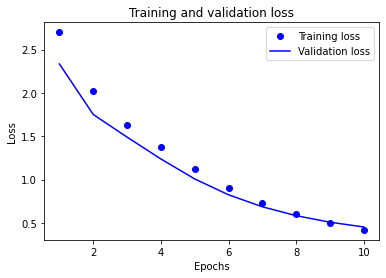

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

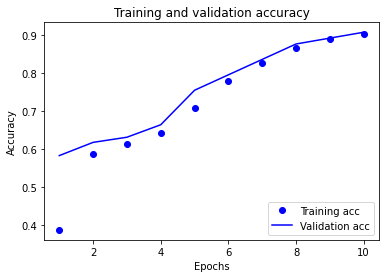

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
import gensim
import string
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def tokenize(file_text):
  tokens = word_tokenize(file_text)

  tokens = [i for i in tokens if (i not in string.punctuation)]

  stop_words = stopwords.words('russian')
  stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', '–', 'к', 'на', '...','/n' , companies_names[0]])
  tokens = [i for i in tokens if (i not in stop_words)]

  return tokens